# Defining the problem
In the realm of hiring and talent acquisition, understanding a candidate's personality
traits is essential for determining their compatibility with a company's culture and job
requirements. As reported by the New York Times, the psychometrics field is a $2
billion dollar industry with over 2000 personality tests on the market currently. The
Myers-Briggs Type Indicator (MBTI) is one of the most widely recognised framework
for assessing personality types in the world, with more than 3.5 million assessments
administered annually. It is used in 26 countries to assess employees, students,
soldiers and potential marriage partners. 

This project aims to develop a predictive model that can accurately determine a person's MBTI based on their texts posted on social media platforms. The project aims to develop a tool for companies to quickly
gain insight into the personalities of their potential hires to make informed candidate
selection decisions, maximise the potential of their employees and better manage the
culture of the firm.

A successful implementation of such a classifier would demonstrate a strong linguistic
basis for MBTI and potentially personality in general. Furthermore, the ability to
produce an accurate text-based classifier has significant potential implications for the
field of psychology itself, since the connection between natural language and
personality type is non-trivial.

# Assembling the Dataset 
In this section, we will be doing the following: 

1. Import necessary libraries and modules
2. Load dataset 
3. Data Cleaning 
4. Exploratory Data Analysis (EDA) 

## 1. Import necessary libraries and modules

In [1]:
!pip install xgboost
!pip install squarify
!python -m pip uninstall -y imbalanced-learn
!pip install scikit-learn==0.24.2
!pip install imblearn

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
    
from nltk.corpus import stopwords

import re
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve
from sklearn.naive_bayes import MultinomialNB

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

import plotly.express as px
import warnings


from sklearn.neighbors import KNeighborsClassifier
import imblearn
from imblearn.over_sampling import SMOTE

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import GRU
from keras.layers import SimpleRNN
from keras.layers import Embedding
from keras.preprocessing import sequence
from keras.preprocessing import text
from keras.optimizers import Adam
# outdated: from keras.preprocessing import sequence 
from keras.utils.data_utils import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences

import squarify
from sklearn.metrics import f1_score

import nltk
from nltk.stem import WordNetLemmatizer

/Users/suhyun/opt/anaconda3/lib/python3.9/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(
2023-09-01 21:04:24.978110: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2. Load Dataset

### Create a dataframe

In [7]:
df = pd.read_csv('mbti_1.csv')
#df = pd.read_csv('mbti_1.csv', index_col=False)
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


### Understanding the structure of the dataset
Before we start cleaning our data, we need to first understand our raw dataset so that we can determine what to clean.

In [ ]:
print(df.shape)

In [ ]:
# display info/data types of data 
df.info()

From the above results, we can deduce that there are:
* 8675 data values 
* 2 Columns - Type and Posts
* Object datatype

### Understanding the data

#### type (y data)

In [ ]:
df['type']

#### Uncleaned posts (x data)

In [ ]:
df.posts[0]

## 3. Data Cleaning
Data cleaning is the process of fixing or removing incorrect, corrupted, incorrectly formatted, duplicate, or incomplete data within a dataset. Cleaning our dataset ensures data accuracy, reliability and quality for effective analysis and modelling. 

* Case Standardisation
* Remove Stopwords
* Remove URLs and punctuations
* Lemmatization

In [9]:
def clean_data(x):
    data_length=[]
    wnl=WordNetLemmatizer()
    cleaned_text=[]
    stop_words = set(stopwords.words('english')) # Load stop words
    mbti_types = [ "ISTJ", "ESFJ", "ISTJ","ISFP",
                  "ESTJ", "ESFP", "ENFP","ISTP",
                  "INFP", "ESTP", "INTP", "ENTP", 
                  "ENFJ", "INTJ", "ENTJ", "INFJ" ]
    mbti_types = [t.lower() for t in mbti_types]
    
    for sent in df.posts:
        
        # Case Standardisation
        sent=sent.lower()
        
        # Remove URLs
        # source: Gabriel Giraldo-Wingler https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python
        sent=re.sub('(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*',' ',sent)
        
        # Remove punctuations
        sent=re.sub('[^0-9a-z]',' ',sent)
        
        # Remove stop words
        sent = " ".join([word for word in sent.split() if word not in stop_words]) 
        
        for t in mbti_types:
            sent = re.sub(t, '', sent)
            
        # Lemmatize
        sent = wnl.lemmatize(sent) 
        
        data_length.append(len(sent.split())) #Split data, measure length of new filtered data
        
        cleaned_text.append(sent)
        
    return cleaned_text,data_length

In [10]:
class Lemmatizer(object):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()

    def __call__(self, sentence):
        return [self.lemmatizer.lemmatize(word) for word in sentence.split() if len(word)>2]

In [11]:
df_clean = df
df_clean.posts,df_clean_length=clean_data(df)
df_clean

,type,posts
0,INFJ,jpg moments sportscenter top ten plays prank...
1,ENTP,finding lack posts alarming sex boring positio...
2,INTP,good one course say know blessing curse absolu...
3,INTJ,dear enjoyed conversation day esoteric gabbin...
4,ENTJ,fired another silly misconception approaching ...
...,...,...
8670,ISFP,ixfp always think cats fi doms reason especial...
8671,ENFP,thread already exists someplace else html post...
8672,INTP,many questions things would take purple pill p...
8673,INFP,conflicted right comes wanting children honest...


## 4. EDA
In this section, we will carry out EDA on the cleaned data to find meaningful information in our dataset that may be useful for our project.

#### Cleaned data

In [12]:
df_clean.posts[0]

'jpg   moments sportscenter top ten plays pranks life changing experience life repeat today may perc experience immerse last thing  friend posted facebook committing suicide next day rest peace hello 7 sorry hear distress natural relationship perfection time every moment existence try figure hard times times growth 84389 84390 jpg jpg welcome stuff jpg game set match prozac wellbrutin least thirty minutes moving legs mean moving sitting desk chair weed moderation maybe try edibles healthier alternative basically come three items determined type whichever types want would likely use given types cognitive functions whatnot left things moderation sims indeed video game good one note good one somewhat subjective completely promoting death given sim dear  favorite video games growing current favorite video games cool appears late sad someone everyone wait thought confidence good thing cherish time solitude b c revel within inner world whereas time workin enjoy time worry people always aroun

#### MBTI distribution in the dataset

In [ ]:
# count data for each personality type 
df['type'].value_counts()

#### Visualise MBTI distribution 

In [ ]:
# visualise mbti type distribution in a count plot
plt.figure(figsize=(15,7))
chart = sns.countplot(x=df["type"])
chart.set(title="MBTI Type Distribution")

We can see that the dataset is disproportionate. We will have to balance the data before feeding it into our machine learning models later in the project.

#### 50 Most Common Words

In [ ]:
from collections import Counter 
words = list(df["posts"].apply(lambda x: x.split()))
words = [x for y in words for x in y]
Counter(words).most_common(50)

#### Wordclouds

In [ ]:
fig, ax = plt.subplots(len(df_clean['type'].unique()), figsize=(15, len(df_clean['type'].unique())))
plt.suptitle("Wordcloud for MBTI types")
k=0
for i in df_clean['type'].unique():
    df_4=df[df_clean['type'] == i]
    wordcloud = WordCloud(max_words=1628, relative_scaling=1, normalize_plurals=False).generate(df_4['posts'].to_string())
    plt.subplot(4,4,k+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(i)
    
    ax[k].axis("off")
    k+=1

# Choosing a measure of success

## Accuracy 

The measure of success I have chosen to use is accuracy. Accuracy is well-suited to the specific nature of this project for several reasons.

Firstly, the project involves predicting MBTI personality types. In this context, the consequences of a false positive, where the model predicts the wrong personality type, are not severe. There are no ethical implications or critical outcomes associated with such errors. False positives may result in additional work but does not carry significant adverse effects.

Secondly, accuracy is an intuitive and interpretable metric for both technical and non-technical stakeholders. It provides a straightforward assessment of the model's performance by quantifying the proportion of correct predictions.

Thirdly, the choice of accuracy is bolstered by the use of categorical cross-entropy as the loss function. This loss function is specifically tailored for multiclass classification tasks, aligning with our project's objective of predicting MBTI personality types.

# Deciding on an evaluation protocol

## Iterated K-Fold Cross-Validation

Considering my relatively small dataset containing 8675 data and the emphasis on achieving high model accuracy, the iterated k-Fold Cross-Validation approach would be the best evaluation protocol. 

Given the limited dataset size, this approach minimizes the risk of overfitting, as it repeatedly assesses the model on diverse data subsets. Iterated k-Fold Cross-Validation combines the advantages of k-Fold Cross-Validation with the robustness gained from repeated iterations. This protocol partitions the dataset into k subsets, or "folds," and iteratively uses each fold as a validation set while training the model on the remaining data. This process is repeated multiple times, shuffling the data differently in each iteration. This reduces the impact of variability introduced by the random splitting of data leading to a more reliable assessment of your model's ability to generalize to new, unseen data. 

## Baseline

A baseline model serves as a starting point for comparison in machine learning tasks, representing a simple or default approach to establish a performance benchmark.

As there are a total of 16 distinct labels in our dataset, the percentage of accuracy is 1/16 = 0.0625 or 6.25%. 

We will use this value as our baseline to aim to develop a model that produces an accuracy of greater than 0.0625 in order to achieve statistical power. 

# Preparing your data (for training)

### 1. Split data into train and test sets
The dataset is divided into training and testing sets in a 80:20 ratio. The training set is used for training the model and the testing set is used as a collection of data points that will help to assess the performance of the model in generalising new, unseen data

In [19]:
X = df['posts']
y = df['type']

X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(df_clean['posts'],df_clean['type'], 
                                         test_size=0.2,
                                         random_state=0, 
                                         stratify= df.type)  

### 2. Label Encoding

Machine Learning cannot interpret strings on our target values. This, we need to convert categorical data into numerical values before they can be fitted into our machine learning models. Each category is assigned a unique integer.

In [20]:
# create an instance of label encoder 
labelencoder= LabelEncoder()
# Fit and transform the labels to numerical format
y_train_lstm_enc = labelencoder.fit_transform(y_train_lstm)
y_test_lstm_enc = labelencoder.transform(y_test_lstm)

### 3. One hot encoding

The model would require categorically encoded labels where each label will be turned into a 10-element vector of zeros except for a single element. This is called one-hot encoding using to_categorical where at the position in the vector that corresponds to the label will be encoded with a one in the (n+1)th position. 

In [21]:
from keras.utils import to_categorical

# One-hot encode the target labels
y_train_lstm_onehot = to_categorical(y_train_lstm_enc)
y_test_lstm_onehot = to_categorical(y_test_lstm_enc)

### 4. Tokenization and Padding Sequences
Tokenization is the process of splitting text into individual words or tokens. Padded sequences are used to make all input sequences of the same length by adding padding tokens. Both are essential for processing text data with varying lengths, as most machine learning models require fixed-length input.

In [22]:
from keras.preprocessing.text import Tokenizer
max_words = 2500
max_len = 40

# ensure all sequences in a list have the same length
def tokenize_pad_sequences(text):
    # initialise text tokenizer
    tokenizer = Tokenizer(num_words=max_words, filters="")
    
    # generate word indexes
    tokenizer.fit_on_texts(text)
    
    # transforms text to a sequence of integers and apply padding 
    X = tokenizer.texts_to_sequences(text)
    X = pad_sequences(X, padding='post', maxlen=max_len) #post padding  
    
    # return sequences 
    return X, tokenizer

In [23]:
from keras.preprocessing.text import Tokenizer
max_words = 2500
max_len = 40

X_train_lstm_pad, tokenizer = tokenize_pad_sequences(X_train_lstm)
X_test_lstm_pad = tokenizer.texts_to_sequences(X_test_lstm)
X_test_lstm_pad = pad_sequences(X_test_lstm_pad, padding='post', maxlen=max_len)

### 5. Word Embedding 

A word embedding is a learned representation for text where words that have the same meaning have a similar representation. It is this approach to representing words and documents that may be considered one of the key breakthroughs of deep learning on challenging natural language processing problems. 

We are using GloVe for this project.

In [24]:
import os
DATA_DIR = "data"
GLOVE_PATH = os.path.join(DATA_DIR, "glove.6B.50d.txt")


# load GloVe embedding 
embeddings_index = dict()
with open(GLOVE_PATH) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefficients = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefficients

In [25]:
max_words = 2500 
EMBEDDING_VECTOR_LENGTH = 50 
# create an embedding matrix 
embedding_matrix = np.zeros((max_words, EMBEDDING_VECTOR_LENGTH))
for word, index in tokenizer.word_index.items():
    if index < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

### 6. Handling Imbalanced Data

To handle the imbalanced data, we will be using SMOTE to balance the class distribution.

In [26]:
# Instantiate the SMOTE class
smote = SMOTE(sampling_strategy='auto', random_state=0)

# Apply SMOTE to your training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_lstm_pad, y_train_lstm_enc)

In [27]:
print('X_train_resampled', X_train_resampled.shape)
print('y_train_resampled', y_train_resampled.shape)

X_train_resampled (23456, 40)
y_train_resampled (23456,)


### Helper functions to plot accuracy and loss graphs 

In [28]:
def plot_loss(loss, val_loss):
    plt.clf() #clear any existing figure
    epochs = range(1, len(loss)+1) #get number of epochs
    # Calculate the average loss over epochs
    avg_loss = [np.mean(loss[:i]) for i in range(1, len(loss) + 1)]
    avg_val_loss = [np.mean(val_loss[:i]) for i in range(1, len(val_loss) + 1)]
    # assign values for each axis
    plt.plot(epochs, avg_loss, 'bo', label="Loss")
    plt.plot(epochs, avg_val_loss, 'b', label="Average Validation Loss")
    #set a title of graph and labels of each axis
    plt.title("Average Training Loss & Validation Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Average Loss')
    plt.legend()
    plt.show()    

In [29]:
def plot_acc(acc, val_acc):
    plt.clf()
    epochs = range(1, len(acc)+1) #gets a number of epochs
    # Calculate the average loss over epochs
    avg_acc = [np.mean(acc[:i]) for i in range(1, len(acc) + 1)]
    avg_val_acc = [np.mean(val_acc[:i]) for i in range(1, len(val_acc) + 1)]
    
    # assign values for each axis
    plt.plot(epochs, avg_acc, 'bo', label="Accuracy")
    plt.plot(epochs, avg_val_acc, 'b', label="Average Validation Accuracy")
    #set a title of graph and labels of each axis
    plt.title("Average Training Accuracy & Validation Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Average Accuracy')
    plt.legend()
    plt.show()     

In [30]:
stop!

SyntaxError: invalid syntax (3319058519.py, line 1)

# LSTM: Developing a model that does better than the baseline

### LSTM 

(insert short explanation of LSTM)

We will be applying our chosen evaluation protocol (iterated k fold validation) when training the model.

Constants:  LSTM layer=128 

#### Building the model
- initialise model 
- add layers to model
- compile model 

In [31]:
# Initialising the model 
underfit_lstm_model = Sequential()

# Defining model: add layers 
underfit_lstm_model.add(Embedding(
    max_words,
    EMBEDDING_VECTOR_LENGTH,
    input_length=max_len,
    weights=[embedding_matrix],
    trainable=True,
)) #glove embedding
underfit_lstm_model.add(LSTM(64, input_shape=(max_len, EMBEDDING_VECTOR_LENGTH))) #LSTM layer 
underfit_lstm_model.add(Dense(16, activation='softmax')) #dense layer - the last one

# Compile model
underfit_lstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

print(underfit_lstm_model.summary())

2023-09-01 21:11:50.492462: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 50)            125000    
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
Total params: 155,480
Trainable params: 155,480
Non-trainable params: 0
_________________________________________________________________
None


#### Train model with Iterated K-fold Validation

In [32]:
import numpy as np 
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error

K=4
num_val_samples = len(X_train_resampled)//K
num_epochs = 1

all_val_acc_1 = []
all_val_loss_1 = []

all_acc_1 = []
all_loss_1 = []
all_acc_history_1 = []
all_loss_history_1 = []

N_iterations=4
N_folds=5
        
for i in range(N_iterations):
    skf = StratifiedKFold(n_splits=N_folds, shuffle=True)
    
    for j, (train_index, val_index) in enumerate(skf.split(X_train_resampled, y_train_resampled)):
        print('processing fold', j)
        
        partial_train_data = X_train_resampled[train_index]
        val_data = X_train_resampled[val_index]
        
        partial_train_targets = y_train_resampled[train_index]
        val_targets = y_train_resampled[val_index]
        
        # One-hot encode the target labels
        partial_train_targets = to_categorical(partial_train_targets, num_classes=16)
        val_targets = to_categorical(val_targets, num_classes=16)
        
        # Train the model (in silent mode, verbose=0)
        underfit_lstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
        results_1 = underfit_lstm_model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=128, verbose=0, validation_data = (val_data, val_targets))
        
        # Evaluate the model on the validation data: loss and accuracy 
        val_loss, val_acc = underfit_lstm_model.evaluate(val_data, val_targets, verbose=0)
        all_val_acc_1.append(val_acc)
        all_val_loss_1.append(val_loss)
        
        acc = results_1.history['accuracy']
        all_acc_1.append(acc)
        acc_history = results_1.history['val_accuracy']
        all_acc_history_1.append(acc_history)
        
        loss = results_1.history['loss']
        all_loss_1.append(loss)
        loss_history = results_1.history['val_loss']
        all_loss_history_1.append(loss_history)

processing fold 0
processing fold 1
processing fold 2
processing fold 3
processing fold 4
processing fold 0
processing fold 1
processing fold 2
processing fold 3
processing fold 4
processing fold 0
processing fold 1
processing fold 2
processing fold 3
processing fold 4
processing fold 0
processing fold 1
processing fold 2
processing fold 3
processing fold 4


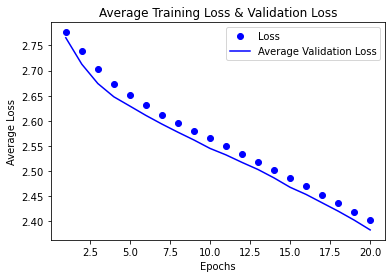

In [33]:
plot_loss(all_loss_1, all_loss_history_1)

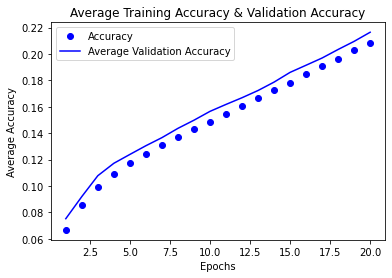

In [34]:
plot_acc(all_acc_1, all_acc_history_1)

In [35]:
print("Average Loss:", np.mean(all_val_loss_1))
print("Average Accuracy:", np.mean(all_val_acc_1))

Average Loss: 2.3830607175827025
Average Accuracy: 0.21643864922225475


From the graphs plotted, we can observe that there is slight underfitting as the accuracy is lower below the average validation accuracy.

Despite being an underfitting model, our model has an average accuracy that is higher (21.6%) than the baseline (6.25%).

Now we will develop a model that overfits. 

# LSTM: Developing a model that overfits/scaled up
After developing a model that is able to do better than the baseline, we need to develop a model that overfits/scaled up. As the aim of this project is to create a model that stands on the line between overfitting and underfitting, we now need to cross the line to develop a model that overfits. 

We will be developing an overfitting model by 
1. <b>increasing the number of LSTM and dense layers</b> 
2. <b>increasing the number of epochs</b>
3. <b>decreasing batch_size</b>

Using the 'relu' (Rectified Linear Unit) activation function for intermediate dense layers and 'softmax' activation for the output layer is a common practice in deep learning for classification tasks. Here's why this combination is used:

Intermediate Layers ('relu' activation): The 'relu' activation function is commonly used in intermediate layers because it introduces non-linearity to the network. This non-linearity allows the model to learn complex patterns in the data. 'relu' is computationally efficient and helps mitigate the vanishing gradient problem during training. It's effective for feature extraction and can model complex relationships in the data.

Output Layer ('softmax' activation): The 'softmax' activation is typically used in the output layer for multi-class classification problems. It transforms the raw output scores of the model into probability distributions over the classes. In other words, it converts the model's final layer outputs into class probabilities, where each class gets a probability score. This is useful because it allows you to interpret the model's output as class probabilities and choose the class with the highest probability as the predicted class.

## >> batch_size = 128 <<

In [37]:
max_len = 40
EMBEDDING_VECTOR_LENGTH = 50

# Initialising the model 
overfit_lstm_model = Sequential()

# Defining model: add layers 
overfit_lstm_model.add(Embedding(
    max_words,
    EMBEDDING_VECTOR_LENGTH,
    input_length=max_len,
    weights=[embedding_matrix],
    trainable=True,
)) #glove embedding
overfit_lstm_model.add(LSTM(128, input_shape=(max_len, EMBEDDING_VECTOR_LENGTH), return_sequences=True)) #LSTM layer
overfit_lstm_model.add(LSTM(64)) 
overfit_lstm_model.add(Dense(64, activation='relu')) # Additional dense layer
overfit_lstm_model.add(Dense(16, activation='softmax')) #dense layer - the last one


# Compile model
overfit_lstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

print(overfit_lstm_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 40, 50)            125000    
                                                                 
 lstm_3 (LSTM)               (None, 40, 128)           91648     
                                                                 
 lstm_4 (LSTM)               (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
Total params: 271,256
Trainable params: 271,256
Non-trainable params: 0
_________________________________________________________________
None


#### Train model with Iterated K-fold Validation 
The number of epochs we have used in training the neural network is very small as it takes extremely long to run the training if the number of epochs exceeds 5. In reality, the epoch number should be much higher to ensure better training. 

In [38]:
import numpy as np 
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error

K=4
num_val_samples = len(X_train_resampled)//K
num_epochs = 5

#new!
all_val_acc_2 = []
all_val_loss_2 = []

all_acc_2 = []
all_loss_2 = []
all_acc_history_2 = []
all_loss_history_2 = []

N_iterations=4
N_folds=5
        
for i in range(N_iterations):
    skf = StratifiedKFold(n_splits=N_folds, shuffle=True)
    
    for j, (train_index, val_index) in enumerate(skf.split(X_train_resampled, y_train_resampled)):
        print('processing fold', j)
        
        partial_train_data = X_train_resampled[train_index]
        val_data = X_train_resampled[val_index]
        
        partial_train_targets = y_train_resampled[train_index]
        val_targets = y_train_resampled[val_index]
        
        # One-hot encode the target labels
        partial_train_targets = to_categorical(partial_train_targets, num_classes=16)
        val_targets = to_categorical(val_targets, num_classes=16)
        
        # Train the model (in silent mode, verbose=0)
        overfit_lstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
        results_2 = overfit_lstm_model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=128, verbose=0, validation_data = (val_data, val_targets))
        
        # Evaluate the model on the validation data: loss and accuracy 
        val_loss, val_acc = overfit_lstm_model.evaluate(val_data, val_targets, verbose=0)
        all_val_acc_2.append(val_acc)
        all_val_loss_2.append(val_loss)
        
        acc = results_2.history['accuracy']
        all_acc_2.append(acc)
        acc_history = results_2.history['val_accuracy']
        all_acc_history_2.append(acc_history)
        
        loss = results_2.history['loss']
        all_loss_2.append(loss)
        loss_history = results_2.history['val_loss']
        all_loss_history_2.append(loss_history)

processing fold 0
processing fold 1
processing fold 2
processing fold 3
processing fold 4
processing fold 0
processing fold 1
processing fold 2
processing fold 3
processing fold 4
processing fold 0
processing fold 1
processing fold 2
processing fold 3
processing fold 4
processing fold 0
processing fold 1
processing fold 2
processing fold 3
processing fold 4


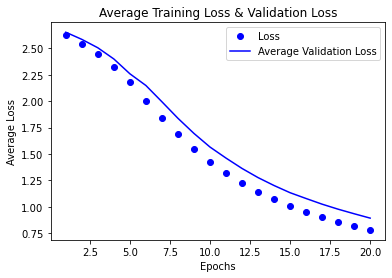

In [39]:
plot_loss(all_loss_2, all_loss_history_2)

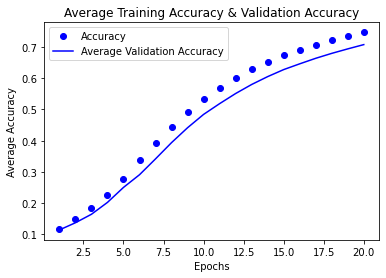

In [40]:
plot_acc(all_acc_2, all_acc_history_2)

In [41]:
print("Average Loss:", np.mean(all_val_loss_2))
print("Average Accuracy:", np.mean(all_val_acc_2))

Average Loss: 0.9967752762138844
Average Accuracy: 0.6761210460215807


In [72]:
max_len = 40
EMBEDDING_VECTOR_LENGTH = 50

# Initialising the model 
overfit_lstm_model = Sequential()

# Defining model: add layers 
overfit_lstm_model.add(Embedding(
    max_words,
    EMBEDDING_VECTOR_LENGTH,
    input_length=max_len,
    weights=[embedding_matrix],
    trainable=True,
)) #glove embedding
overfit_lstm_model.add(LSTM(128, input_shape=(max_len, EMBEDDING_VECTOR_LENGTH), return_sequences=True)) #LSTM layer
overfit_lstm_model.add(LSTM(64)) 
overfit_lstm_model.add(Dense(64, activation='relu')) # Additional dense layer
overfit_lstm_model.add(Dense(16, activation='softmax')) #dense layer - the last one


# Compile model
overfit_lstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

print(overfit_lstm_model.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 40, 50)            125000    
                                                                 
 lstm_33 (LSTM)              (None, 40, 128)           91648     
                                                                 
 lstm_34 (LSTM)              (None, 64)                49408     
                                                                 
 dense_29 (Dense)            (None, 64)                4160      
                                                                 
 dense_30 (Dense)            (None, 16)                1040      
                                                                 
Total params: 271,256
Trainable params: 271,256
Non-trainable params: 0
_________________________________________________________________
None


## >> batch_size = 50 <<

In [73]:
import numpy as np 
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error

K=4
num_val_samples = len(X_train_resampled)//K
num_epochs = 5

#new!
all_val_acc_2 = []
all_val_loss_2 = []

all_acc_2 = []
all_loss_2 = []
all_acc_history_2 = []
all_loss_history_2 = []

N_iterations=4
N_folds=5
        
for i in range(N_iterations):
    skf = StratifiedKFold(n_splits=N_folds, shuffle=True)
    
    for j, (train_index, val_index) in enumerate(skf.split(X_train_resampled, y_train_resampled)):
        print('processing fold', j)
        
        partial_train_data = X_train_resampled[train_index]
        val_data = X_train_resampled[val_index]
        
        partial_train_targets = y_train_resampled[train_index]
        val_targets = y_train_resampled[val_index]
        
        # One-hot encode the target labels
        partial_train_targets = to_categorical(partial_train_targets, num_classes=16)
        val_targets = to_categorical(val_targets, num_classes=16)
        
        # Train the model (in silent mode, verbose=0)
        overfit_lstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
        results_2 = overfit_lstm_model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=50, verbose=0, validation_data = (val_data, val_targets))
        
        # Evaluate the model on the validation data: loss and accuracy 
        val_loss, val_acc = overfit_lstm_model.evaluate(val_data, val_targets, verbose=0)
        all_val_acc_2.append(val_acc)
        all_val_loss_2.append(val_loss)
        
        acc = results_2.history['accuracy']
        all_acc_2.append(acc)
        acc_history = results_2.history['val_accuracy']
        all_acc_history_2.append(acc_history)
        
        loss = results_2.history['loss']
        all_loss_2.append(loss)
        loss_history = results_2.history['val_loss']
        all_loss_history_2.append(loss_history)

processing fold 0
processing fold 1
processing fold 2
processing fold 3
processing fold 4
processing fold 0
processing fold 1
processing fold 2
processing fold 3
processing fold 4
processing fold 0
processing fold 1
processing fold 2
processing fold 3
processing fold 4
processing fold 0
processing fold 1
processing fold 2
processing fold 3
processing fold 4


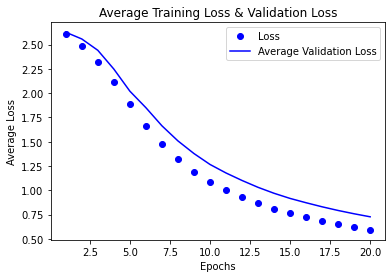

In [74]:
plot_loss(all_loss_2, all_loss_history_2)

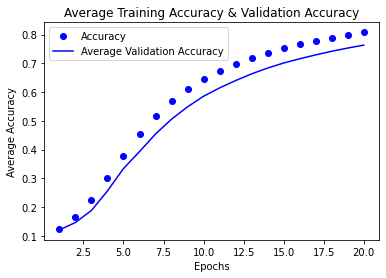

In [75]:
plot_acc(all_acc_2, all_acc_history_2)

In [76]:
print("Average Loss:", np.mean(all_val_loss_2))
print("Average Accuracy:", np.mean(all_val_acc_2))

Average Loss: 0.8718613050878048
Average Accuracy: 0.7233157001435757


## batch_size = 10

#### Building the overfitting LSTM model
- initialise model
- add layers to model
- compile model

In [81]:
max_len = 40
EMBEDDING_VECTOR_LENGTH = 50

# Initialising the model 
overfit_lstm_model = Sequential()

# Defining model: add layers 
overfit_lstm_model.add(Embedding(
    max_words,
    EMBEDDING_VECTOR_LENGTH,
    input_length=max_len,
    weights=[embedding_matrix],
    trainable=True,
)) #glove embedding
overfit_lstm_model.add(LSTM(128, input_shape=(max_len, EMBEDDING_VECTOR_LENGTH), return_sequences=True)) #LSTM layer
overfit_lstm_model.add(LSTM(64)) 
overfit_lstm_model.add(Dense(64, activation='relu')) # Additional dense layer
overfit_lstm_model.add(Dense(16, activation='softmax')) #dense layer - the last one


# Compile model
overfit_lstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

print(overfit_lstm_model.summary())

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 40, 50)            125000    
                                                                 
 lstm_35 (LSTM)              (None, 40, 128)           91648     
                                                                 
 lstm_36 (LSTM)              (None, 64)                49408     
                                                                 
 dense_31 (Dense)            (None, 64)                4160      
                                                                 
 dense_32 (Dense)            (None, 16)                1040      
                                                                 
Total params: 271,256
Trainable params: 271,256
Non-trainable params: 0
_________________________________________________________________
None


#### Train model with Iterated K-fold Validation 
The number of epochs we have used in training the neural network is very small as it takes extremely long to run the training if the number of epochs exceeds 5. In reality, the epoch number should be much higher to ensure better training. 

In [77]:
import numpy as np 
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error

K=4
num_val_samples = len(X_train_resampled)//K
num_epochs = 5

#new!
all_val_acc_2 = []
all_val_loss_2 = []

all_acc_2 = []
all_loss_2 = []
all_acc_history_2 = []
all_loss_history_2 = []

N_iterations=4
N_folds=5
        
for i in range(N_iterations):
    skf = StratifiedKFold(n_splits=N_folds, shuffle=True)
    
    for j, (train_index, val_index) in enumerate(skf.split(X_train_resampled, y_train_resampled)):
        print('processing fold', j)
        
        partial_train_data = X_train_resampled[train_index]
        val_data = X_train_resampled[val_index]
        
        partial_train_targets = y_train_resampled[train_index]
        val_targets = y_train_resampled[val_index]
        
        # One-hot encode the target labels
        partial_train_targets = to_categorical(partial_train_targets, num_classes=16)
        val_targets = to_categorical(val_targets, num_classes=16)
        
        # Train the model (in silent mode, verbose=0)
        overfit_lstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
        results_2 = overfit_lstm_model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=10, verbose=0, validation_data = (val_data, val_targets))
        
        # Evaluate the model on the validation data: loss and accuracy 
        val_loss, val_acc = overfit_lstm_model.evaluate(val_data, val_targets, verbose=0)
        all_val_acc_2.append(val_acc)
        all_val_loss_2.append(val_loss)
        
        acc = results_2.history['accuracy']
        all_acc_2.append(acc)
        acc_history = results_2.history['val_accuracy']
        all_acc_history_2.append(acc_history)
        
        loss = results_2.history['loss']
        all_loss_2.append(loss)
        loss_history = results_2.history['val_loss']
        all_loss_history_2.append(loss_history)

processing fold 0
processing fold 1
processing fold 2
processing fold 3
processing fold 4
processing fold 0
processing fold 1
processing fold 2
processing fold 3
processing fold 4
processing fold 0
processing fold 1
processing fold 2
processing fold 3
processing fold 4
processing fold 0
processing fold 1
processing fold 2
processing fold 3
processing fold 4


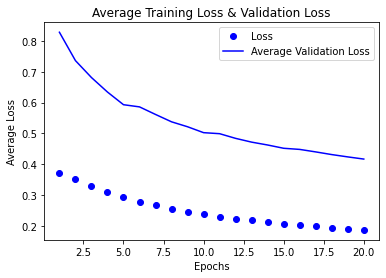

In [79]:
plot_loss(all_loss_2, all_loss_history_2)

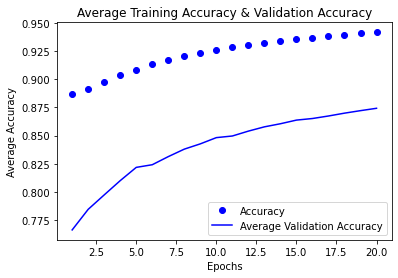

In [78]:
plot_acc(all_acc_2, all_acc_history_2)

In [80]:
print("Average Loss:", np.mean(all_val_loss_2))
print("Average Accuracy:", np.mean(all_val_acc_2))

Average Loss: 0.6029456093907356
Average Accuracy: 0.8255579173564911


From the plotted graphs, we can see the training accuracy being significantly higher than the average validation accuracy which suggests that the model is overfitting. The average accuracy of our overfitting model is 82.6% which is almost 4 times higher than our underfitting model with an accuracy of 21.6%.

Now we will start regularising the hyperparamters of our overfitting model to prevent overfitting and improve the performance of the model.

## Decreased num_epoch from 5 to 1 to speed up training but model was underfitting.

In [90]:
import numpy as np 
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error

K=4
num_val_samples = len(X_train_resampled)//K
num_epochs = 1

#new!
all_val_acc_2 = []
all_val_loss_2 = []

all_acc_2 = []
all_loss_2 = []
all_acc_history_2 = []
all_loss_history_2 = []

N_iterations=4
N_folds=5
        
for i in range(N_iterations):
    skf = StratifiedKFold(n_splits=N_folds, shuffle=True)
    
    for j, (train_index, val_index) in enumerate(skf.split(X_train_resampled, y_train_resampled)):
        print('processing fold', j)
        
        partial_train_data = X_train_resampled[train_index]
        val_data = X_train_resampled[val_index]
        
        partial_train_targets = y_train_resampled[train_index]
        val_targets = y_train_resampled[val_index]
        
        # One-hot encode the target labels
        partial_train_targets = to_categorical(partial_train_targets, num_classes=16)
        val_targets = to_categorical(val_targets, num_classes=16)
        
        # Train the model (in silent mode, verbose=0)
        overfit_lstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
        results_2 = overfit_lstm_model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=10, verbose=0, validation_data = (val_data, val_targets))
        
        # Evaluate the model on the validation data: loss and accuracy 
        val_loss, val_acc = overfit_lstm_model.evaluate(val_data, val_targets, verbose=0)
        all_val_acc_2.append(val_acc)
        all_val_loss_2.append(val_loss)
        
        acc = results_2.history['accuracy']
        all_acc_2.append(acc)
        acc_history = results_2.history['val_accuracy']
        all_acc_history_2.append(acc_history)
        
        loss = results_2.history['loss']
        all_loss_2.append(loss)
        loss_history = results_2.history['val_loss']
        all_loss_history_2.append(loss_history)

processing fold 0
processing fold 1
processing fold 2
processing fold 3
processing fold 4
processing fold 0
processing fold 1
processing fold 2
processing fold 3
processing fold 4
processing fold 0
processing fold 1
processing fold 2
processing fold 3
processing fold 4
processing fold 0
processing fold 1
processing fold 2
processing fold 3
processing fold 4


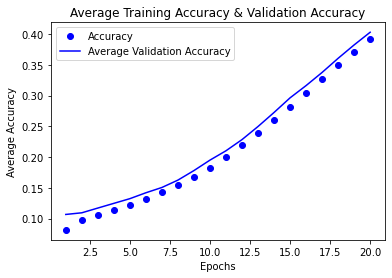

In [91]:
plot_acc(all_acc_2, all_acc_history_2)

# LSTM: Regularizing your model and tuning your hyperparameters
After creating a model that overfits, we need to modify the model to increase the peformance of the model. We can do this by regularizing the model and iteratively fine tune our hyperparameters until we determine the optimal hyperparameter settings that results in the best performing machine learning model.

There are many ways to regularize the model. For our project, we will be tuning:
1. Dropout rates
2. L1/L2 regularizers

Batch Normalization will also be applied to accelerate training of the model.

We will be testing different settings for the hyperparameters and compare the performances between them to determine the optimal setting for dropout and L1/L2 regularizers.

Finally, we will add the hyperparameters with the optimal values we found earlier to our overfitting LSTM model to develop the final LSTM model.

### 1. Dropout

By adding dropout layers, you introduce some randomness during training, which can help prevent the model from relying too heavily on any single feature and reduce overfitting. 

#### Build model with Dropout = 0.1

In [82]:
### DROP OUT = 0.1 ###

from tensorflow.keras.layers import Dropout

# Initialising the model 
lstm_model_1 = Sequential()

# Defining model: add layers 
lstm_model_1.add(Embedding(
    max_words,
    EMBEDDING_VECTOR_LENGTH,
    input_length=max_len,
    weights=[embedding_matrix],
    trainable=True,
)) #glove embedding


lstm_model_1.add(Dropout(0.1)) #dropout layer with 0.1 rate
lstm_model_1.add(LSTM(128, input_shape=(max_len, EMBEDDING_VECTOR_LENGTH), return_sequences=True))
lstm_model_1.add(LSTM(64))
lstm_model_1.add(Dense(64, activation='relu'))
lstm_model_1.add(Dropout(0.1))
lstm_model_1.add(Dense(16, activation='softmax'))


# lstm_model_1.add(LSTM(128, input_shape=(max_len, EMBEDDING_VECTOR_LENGTH))) #LSTM layer
# lstm_model_1.add(Dropout(0.1))
# lstm_model_1.add(LSTM(64)) # Additional dense layer
# lstm_model_1.add(Dense(64, activation='relu')) # Additional dense layer
# lstm_model_1.add(Dropout(0.1))
# lstm_model_1.add(Dense(16, activation='softmax')) #dense layer - the last one


# Compile model
lstm_model_1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

print(lstm_model_1.summary())


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 40, 50)            125000    
                                                                 
 dropout (Dropout)           (None, 40, 50)            0         
                                                                 
 lstm_37 (LSTM)              (None, 40, 128)           91648     
                                                                 
 lstm_38 (LSTM)              (None, 64)                49408     
                                                                 
 dense_33 (Dense)            (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_34 (Dense)            (None, 16)              

#### Train model with Dropout = 0.1

In [84]:
import numpy as np 
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error

K=4
num_val_samples = len(X_train_resampled)//K
num_epochs = 5

#new!
all_val_acc_3 = []
all_val_loss_3 = []

all_acc_3 = []
all_loss_3 = []
all_acc_history_3 = []
all_loss_history_3 = []

N_iterations=4
N_folds=5
        
for i in range(N_iterations):
    skf = StratifiedKFold(n_splits=N_folds, shuffle=True)
    
    for j, (train_index, val_index) in enumerate(skf.split(X_train_resampled, y_train_resampled)):
        print('processing fold', j)
        
        partial_train_data = X_train_resampled[train_index]
        val_data = X_train_resampled[val_index]
        
        partial_train_targets = y_train_resampled[train_index]
        val_targets = y_train_resampled[val_index]
        
        # One-hot encode the target labels
        partial_train_targets = to_categorical(partial_train_targets, num_classes=16)
        val_targets = to_categorical(val_targets, num_classes=16)
        
        # Train the model 
        lstm_model_1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
        results_3 = lstm_model_1.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=10, verbose=2, validation_data = (val_data, val_targets))
        
        # Evaluate the model on the validation data: loss and accuracy 
        val_loss, val_acc = lstm_model_1.evaluate(val_data, val_targets, verbose=0)
        all_val_acc_3.append(val_acc)
        all_val_loss_3.append(val_loss)
        
        acc = results_3.history['accuracy']
        all_acc_3.append(acc)
        acc_history = results_3.history['val_accuracy']
        all_acc_history_3.append(acc_history)
        
        loss = results_3.history['loss']
        all_loss_3.append(loss)
        loss_history = results_3.history['val_loss']
        all_loss_history_3.append(loss_history)

processing fold 0
Epoch 1/5
1877/1877 - 71s - loss: 1.4801 - accuracy: 0.5077 - val_loss: 1.2957 - val_accuracy: 0.5620 - 71s/epoch - 38ms/step
Epoch 2/5
1877/1877 - 71s - loss: 1.3712 - accuracy: 0.5420 - val_loss: 1.3720 - val_accuracy: 0.5332 - 71s/epoch - 38ms/step
Epoch 3/5
1877/1877 - 72s - loss: 1.2970 - accuracy: 0.5610 - val_loss: 1.4595 - val_accuracy: 0.5038 - 72s/epoch - 38ms/step
Epoch 4/5
1877/1877 - 67s - loss: 1.2071 - accuracy: 0.5923 - val_loss: 1.5900 - val_accuracy: 0.4736 - 67s/epoch - 35ms/step
Epoch 5/5
1877/1877 - 67s - loss: 1.1451 - accuracy: 0.6114 - val_loss: 1.7102 - val_accuracy: 0.4410 - 67s/epoch - 36ms/step
processing fold 1
Epoch 1/5
1877/1877 - 75s - loss: 1.3306 - accuracy: 0.5647 - val_loss: 0.8449 - val_accuracy: 0.7470 - 75s/epoch - 40ms/step
Epoch 2/5
1877/1877 - 71s - loss: 1.2013 - accuracy: 0.6046 - val_loss: 0.9451 - val_accuracy: 0.6967 - 71s/epoch - 38ms/step
Epoch 3/5
1877/1877 - 67s - loss: 1.1236 - accuracy: 0.6255 - val_loss: 1.0466 - v

Epoch 5/5
1877/1877 - 73s - loss: 0.4333 - accuracy: 0.8596 - val_loss: 0.2784 - val_accuracy: 0.9062 - 73s/epoch - 39ms/step
processing fold 3
Epoch 1/5
1877/1877 - 69s - loss: 0.5473 - accuracy: 0.8265 - val_loss: 0.1006 - val_accuracy: 0.9774 - 69s/epoch - 37ms/step
Epoch 2/5
1877/1877 - 56s - loss: 0.4884 - accuracy: 0.8416 - val_loss: 0.1335 - val_accuracy: 0.9699 - 56s/epoch - 30ms/step
Epoch 3/5
1877/1877 - 55s - loss: 0.4611 - accuracy: 0.8490 - val_loss: 0.1648 - val_accuracy: 0.9540 - 55s/epoch - 29ms/step
Epoch 4/5
1877/1877 - 68s - loss: 0.4346 - accuracy: 0.8555 - val_loss: 0.2047 - val_accuracy: 0.9339 - 68s/epoch - 36ms/step
Epoch 5/5
1877/1877 - 62s - loss: 0.4402 - accuracy: 0.8583 - val_loss: 0.2517 - val_accuracy: 0.9192 - 62s/epoch - 33ms/step
processing fold 4
Epoch 1/5
1877/1877 - 115s - loss: 0.5268 - accuracy: 0.8302 - val_loss: 0.0864 - val_accuracy: 0.9851 - 115s/epoch - 61ms/step
Epoch 2/5
1877/1877 - 55s - loss: 0.4605 - accuracy: 0.8503 - val_loss: 0.1268 -

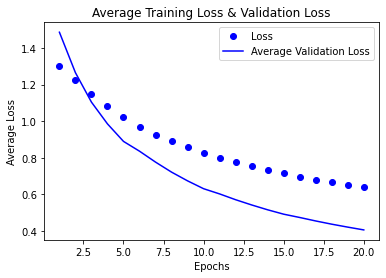

In [85]:
plot_loss(all_loss_3, all_loss_history_3)

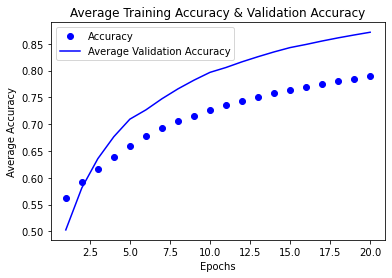

In [86]:
plot_acc(all_acc_3, all_acc_history_3)

In [87]:
print("Average Loss:", np.mean(all_val_loss_3))
print("Average Accuracy:", np.mean(all_val_acc_3))

Average Loss: 0.5251037381589413
Average Accuracy: 0.8255921095609665


From the graphs plotted above, we can see that the training accuracy is now below the averge validation accuracy which suggest undefitting.

Upon adding dropouts of 0.1, the overfitting model became underfitting. As the aim of the project is to create a model that stands on the line between overfitting and underfitting, we need to reduce the underfitting by using a dropout rate that is smaller than 0.1.

#### Build Model with Dropout=0.07

In [92]:
### DROP OUT = 0.07 ###

from tensorflow.keras.layers import Dropout

# Initialising the model 
lstm_model_2 = Sequential()

# Defining model: add layers 
lstm_model_2.add(Embedding(
    max_words,
    EMBEDDING_VECTOR_LENGTH,
    input_length=max_len,
    weights=[embedding_matrix],
    trainable=True,
)) #glove embedding

lstm_model_2.add(Dropout(0.07)) #dropout layer with 0.5 rate
lstm_model_2.add(LSTM(128, input_shape=(max_len, EMBEDDING_VECTOR_LENGTH), return_sequences=True))
lstm_model_2.add(LSTM(64))
lstm_model_2.add(Dense(64, activation='relu'))
lstm_model_2.add(Dropout(0.07))
lstm_model_2.add(Dense(16, activation='softmax'))

# Compile model
lstm_model_2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

print(lstm_model_2.summary())

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 40, 50)            125000    
                                                                 
 dropout_2 (Dropout)         (None, 40, 50)            0         
                                                                 
 lstm_41 (LSTM)              (None, 40, 128)           91648     
                                                                 
 lstm_42 (LSTM)              (None, 64)                49408     
                                                                 
 dense_37 (Dense)            (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_38 (Dense)            (None, 16)              

#### Train the Model with Dropout = 0.07

In [93]:
import numpy as np 
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error

K=4
num_val_samples = len(X_train_resampled)//K
num_epochs = 5

all_val_acc_4 = []
all_val_loss_4 = []

all_acc_4 = []
all_loss_4 = []
all_acc_history_4 = []
all_loss_history_4 = []

N_iterations=4
N_folds=5
        
for i in range(N_iterations):
    skf = StratifiedKFold(n_splits=N_folds, shuffle=True)
    
    for j, (train_index, val_index) in enumerate(skf.split(X_train_resampled, y_train_resampled)):
        print('processing fold', j)
        
        partial_train_data = X_train_resampled[train_index]
        val_data = X_train_resampled[val_index]
        
        partial_train_targets = y_train_resampled[train_index]
        val_targets = y_train_resampled[val_index]
        
        # One-hot encode the target labels
        partial_train_targets = to_categorical(partial_train_targets, num_classes=16)
        val_targets = to_categorical(val_targets, num_classes=16)
        
        # Train the model 
        lstm_model_2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
        results_4 = lstm_model_2.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=10, verbose=2, validation_data = (val_data, val_targets))
        
        # Evaluate the model on the validation data: loss and accuracy 
        val_loss, val_acc = lstm_model_2.evaluate(val_data, val_targets, verbose=0)
        all_val_acc_4.append(val_acc)
        all_val_loss_4.append(val_loss)
        
        acc = results_4.history['accuracy']
        all_acc_4.append(acc)
        acc_history = results_4.history['val_accuracy']
        all_acc_history_4.append(acc_history)
        
        loss = results_4.history['loss']
        all_loss_4.append(loss)
        loss_history = results_4.history['val_loss']
        all_loss_history_4.append(loss_history)

processing fold 0
Epoch 1/5
1877/1877 - 71s - loss: 2.7634 - accuracy: 0.0699 - val_loss: 2.6928 - val_accuracy: 0.1002 - 71s/epoch - 38ms/step
Epoch 2/5
1877/1877 - 66s - loss: 2.6563 - accuracy: 0.1070 - val_loss: 2.6211 - val_accuracy: 0.1117 - 66s/epoch - 35ms/step
Epoch 3/5
1877/1877 - 69s - loss: 2.5939 - accuracy: 0.1160 - val_loss: 2.6282 - val_accuracy: 0.1138 - 69s/epoch - 37ms/step
Epoch 4/5
1877/1877 - 70s - loss: 2.5512 - accuracy: 0.1303 - val_loss: 2.5971 - val_accuracy: 0.1281 - 70s/epoch - 37ms/step
Epoch 5/5
1877/1877 - 69s - loss: 2.5116 - accuracy: 0.1455 - val_loss: 2.6065 - val_accuracy: 0.1296 - 69s/epoch - 37ms/step
processing fold 1
Epoch 1/5
1877/1877 - 66s - loss: 2.5038 - accuracy: 0.1545 - val_loss: 2.5013 - val_accuracy: 0.1537 - 66s/epoch - 35ms/step
Epoch 2/5
1877/1877 - 57s - loss: 2.4547 - accuracy: 0.1700 - val_loss: 2.4840 - val_accuracy: 0.1644 - 57s/epoch - 30ms/step
Epoch 3/5
1877/1877 - 74s - loss: 2.3794 - accuracy: 0.1990 - val_loss: 2.5040 - v

Epoch 5/5
1877/1877 - 61s - loss: 0.4133 - accuracy: 0.8654 - val_loss: 0.3750 - val_accuracy: 0.8717 - 61s/epoch - 32ms/step
processing fold 3
Epoch 1/5
1877/1877 - 61s - loss: 0.5101 - accuracy: 0.8351 - val_loss: 0.1361 - val_accuracy: 0.9659 - 61s/epoch - 33ms/step
Epoch 2/5
1877/1877 - 56s - loss: 0.4466 - accuracy: 0.8528 - val_loss: 0.1695 - val_accuracy: 0.9531 - 56s/epoch - 30ms/step
Epoch 3/5
1877/1877 - 58s - loss: 0.4116 - accuracy: 0.8651 - val_loss: 0.2302 - val_accuracy: 0.9265 - 58s/epoch - 31ms/step
Epoch 4/5
1877/1877 - 56s - loss: 0.4087 - accuracy: 0.8678 - val_loss: 0.2786 - val_accuracy: 0.9085 - 56s/epoch - 30ms/step
Epoch 5/5
1877/1877 - 57s - loss: 0.4010 - accuracy: 0.8663 - val_loss: 0.3627 - val_accuracy: 0.8806 - 57s/epoch - 31ms/step
processing fold 4
Epoch 1/5
1877/1877 - 60s - loss: 0.4934 - accuracy: 0.8395 - val_loss: 0.1087 - val_accuracy: 0.9740 - 60s/epoch - 32ms/step
Epoch 2/5
1877/1877 - 56s - loss: 0.4270 - accuracy: 0.8621 - val_loss: 0.1569 - v

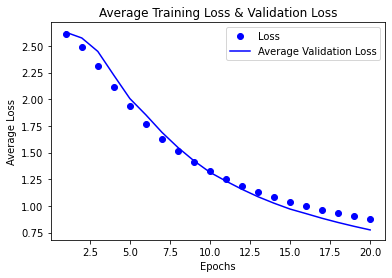

In [94]:
plot_loss(all_loss_4, all_loss_history_4)

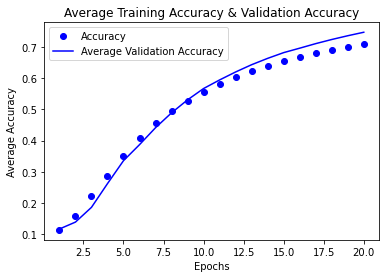

In [95]:
plot_acc(all_acc_4, all_acc_history_4)

In [96]:
print("Average Loss:", np.mean(all_val_loss_4))
print("Average Accuracy:", np.mean(all_val_acc_4))

Average Loss: 0.9011976100504399
Average Accuracy: 0.7035024292767048


The average accuracy for Dropout=0.07 (0.704) is smaller than that of Dropout=0.1(0.826).

The average loss of the former (0.901) is greater than the latter (0.525).

However, from the plotted graphs, we can observe that we have achieved a model with a better fit where the training and validation curves are close to one another without overfitting when Dropout rate was lowered to 0.07.

Hence, we can conclude that a smaller dropout values, dropout=0.07, is better than dropout=0.1 as the former is able to generalise better to unseen data.

### 2. L1/L2 Regularizers + Batch Normalization 

To accelerate the training, we will be adding batch normalization layers after each layer of the neural network. Batch Normalization normalizes and adds noise to the activations of the previous layer, which helps prevent overfitting and makes training more robust.

#### Build the Model with L1/L2 Regularizers = 0.01

In [108]:
from keras.layers import BatchNormalization
from keras import regularizers
from keras.regularizers import l1_l2


# Initialising the model 
lstm_model_5 = Sequential()

# Defining model: add layers 
lstm_model_5.add(Embedding(
    max_words,
    EMBEDDING_VECTOR_LENGTH,
    input_length=max_len,
    weights=[embedding_matrix],
    trainable=True,
)) #glove embedding

lstm_model_5.add(BatchNormalization()) # BatchNormalization layer 
lstm_model_5.add(LSTM(128, input_shape=(max_len, EMBEDDING_VECTOR_LENGTH), return_sequences=True)) #LSTM layer
lstm_model_5.add(BatchNormalization())
lstm_model_5.add(LSTM(64, kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
lstm_model_5.add(BatchNormalization())
lstm_model_5.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01))) 
lstm_model_5.add(BatchNormalization())
lstm_model_5.add(Dense(16, activation='softmax')) #dense layer - the last one

# Compile model
lstm_model_5.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

print(lstm_model_5.summary())

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 40, 50)            125000    
                                                                 
 batch_normalization_18 (Bat  (None, 40, 50)           200       
 chNormalization)                                                
                                                                 
 lstm_55 (LSTM)              (None, 40, 128)           91648     
                                                                 
 batch_normalization_19 (Bat  (None, 40, 128)          512       
 chNormalization)                                                
                                                                 
 lstm_56 (LSTM)              (None, 64)                49408     
                                                                 
 batch_normalization_20 (Bat  (None, 64)             

#### Train the Model with L1/L2 Regularizers = 0.01

In [109]:
import numpy as np 
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error

K=4
num_val_samples = len(X_train_resampled)//K
num_epochs = 5

all_val_acc_7 = []
all_val_loss_7 = []

all_acc_7 = []
all_loss_7 = []
all_acc_history_7 = []
all_loss_history_7 = []

N_iterations=4
N_folds=5
        
for i in range(N_iterations):
    skf = StratifiedKFold(n_splits=N_folds, shuffle=True)
    
    for j, (train_index, val_index) in enumerate(skf.split(X_train_resampled, y_train_resampled)):
        print('processing fold', j)
        
        partial_train_data = X_train_resampled[train_index]
        val_data = X_train_resampled[val_index]
        
        partial_train_targets = y_train_resampled[train_index]
        val_targets = y_train_resampled[val_index]
        
        # One-hot encode the target labels
        partial_train_targets = to_categorical(partial_train_targets, num_classes=16)
        val_targets = to_categorical(val_targets, num_classes=16)
        
        # Train the model 
        lstm_model_5.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
        results_7 = lstm_model_5.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=10, verbose=2, validation_data = (val_data, val_targets))
        
        # Evaluate the model on the validation data: loss and accuracy 
        val_loss, val_acc = lstm_model_5.evaluate(val_data, val_targets, verbose=0)
        all_val_acc_7.append(val_acc)
        all_val_loss_7.append(val_loss)
        
        acc = results_7.history['accuracy']
        all_acc_7.append(acc)
        acc_history = results_7.history['val_accuracy']
        all_acc_history_7.append(acc_history)
        
        loss = results_7.history['loss']
        all_loss_7.append(loss)
        loss_history = results_7.history['val_loss']
        all_loss_history_7.append(loss_history)

processing fold 0
Epoch 1/5
1877/1877 - 91s - loss: 5.8297 - accuracy: 0.0709 - val_loss: 3.5562 - val_accuracy: 0.0693 - 91s/epoch - 48ms/step
Epoch 2/5
1877/1877 - 58s - loss: 3.1224 - accuracy: 0.0774 - val_loss: 2.8359 - val_accuracy: 0.0944 - 58s/epoch - 31ms/step
Epoch 3/5
1877/1877 - 65s - loss: 2.7609 - accuracy: 0.1049 - val_loss: 2.9251 - val_accuracy: 0.0840 - 65s/epoch - 35ms/step
Epoch 4/5
1877/1877 - 56s - loss: 2.7685 - accuracy: 0.1107 - val_loss: 2.7992 - val_accuracy: 0.1093 - 56s/epoch - 30ms/step
Epoch 5/5
1877/1877 - 60s - loss: 2.6877 - accuracy: 0.1190 - val_loss: 2.7784 - val_accuracy: 0.1083 - 60s/epoch - 32ms/step
processing fold 1
Epoch 1/5
1877/1877 - 63s - loss: 2.6675 - accuracy: 0.1186 - val_loss: 2.6199 - val_accuracy: 0.1264 - 63s/epoch - 34ms/step
Epoch 2/5
1877/1877 - 56s - loss: 2.6293 - accuracy: 0.1258 - val_loss: 2.7296 - val_accuracy: 0.1277 - 56s/epoch - 30ms/step
Epoch 3/5
1877/1877 - 56s - loss: 2.6235 - accuracy: 0.1325 - val_loss: 2.6337 - v

Epoch 5/5
1877/1877 - 74s - loss: 1.2375 - accuracy: 0.5585 - val_loss: 1.3978 - val_accuracy: 0.4871 - 74s/epoch - 40ms/step
processing fold 3
Epoch 1/5
1877/1877 - 97s - loss: 1.3214 - accuracy: 0.5365 - val_loss: 1.0378 - val_accuracy: 0.6500 - 97s/epoch - 52ms/step
Epoch 2/5
1877/1877 - 72s - loss: 1.2445 - accuracy: 0.5571 - val_loss: 1.1053 - val_accuracy: 0.5773 - 72s/epoch - 39ms/step
Epoch 3/5
1877/1877 - 75s - loss: 1.2359 - accuracy: 0.5631 - val_loss: 1.2073 - val_accuracy: 0.5609 - 75s/epoch - 40ms/step
Epoch 4/5
1877/1877 - 76s - loss: 1.2206 - accuracy: 0.5692 - val_loss: 1.3172 - val_accuracy: 0.5496 - 76s/epoch - 40ms/step
Epoch 5/5
1877/1877 - 67s - loss: 1.2144 - accuracy: 0.5703 - val_loss: 1.3215 - val_accuracy: 0.5022 - 67s/epoch - 36ms/step
processing fold 4
Epoch 1/5
1877/1877 - 68s - loss: 1.3074 - accuracy: 0.5425 - val_loss: 1.0118 - val_accuracy: 0.6566 - 68s/epoch - 36ms/step
Epoch 2/5
1877/1877 - 63s - loss: 1.2135 - accuracy: 0.5761 - val_loss: 0.9915 - v

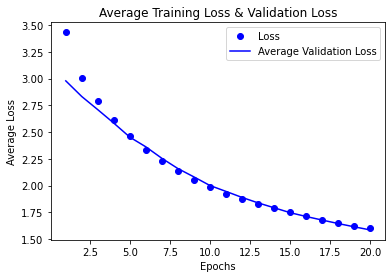

In [110]:
plot_loss(all_loss_7, all_loss_history_7)

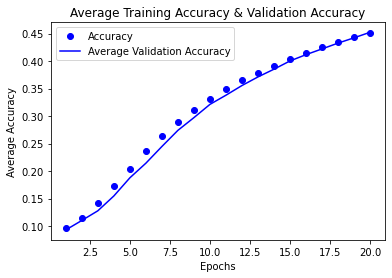

In [111]:
plot_acc(all_acc_7, all_acc_history_7)

In [112]:
print("Average Loss:", np.mean(all_val_loss_7))
print("Average Accuracy:", np.mean(all_val_acc_7))

Average Loss: 1.6897206604480743
Average Accuracy: 0.415236896276474


  compare between regularisers 

#### Build the Model with L1/L2 Regularizers = 0.02

In [ ]:
# from keras.layers import BatchNormalization
# from keras import regularizers
# from keras.regularizers import l1_l2


# # Initialising the model 
# lstm_model_6 = Sequential()

# # Defining model: add layers 
# lstm_model_6.add(Embedding(
#     max_words,
#     EMBEDDING_VECTOR_LENGTH,
#     input_length=max_len,
#     weights=[embedding_matrix],
#     trainable=True,
# )) #glove embedding

# lstm_model_6.add(BatchNormalization()) # BatchNormalization layer 
# lstm_model_6.add(LSTM(128, input_shape=(max_len, EMBEDDING_VECTOR_LENGTH), return_sequences=True)) #LSTM layer
# lstm_model_6.add(BatchNormalization())
# lstm_model_6.add(LSTM(64, kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
# lstm_model_6.add(BatchNormalization())
# lstm_model_6.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01))) 
# lstm_model_6.add(BatchNormalization())
# lstm_model_6.add(Dense(16, activation='softmax')) #dense layer - the last one

# # Compile model
# lstm_model_6.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# print(lstm_model_6.summary())

# Final LSTM Model

Now that we have explored 3 different regularization methods - Dropout, L1/L2 Regularizers and Batch Normalisation and also determined the most optimal hyperparameter settings, we will develop our final model. 

The final model will first be trained with a partial training set before being trained on the complete set.

#### Building the final LSTM Model

In [115]:
from tensorflow.keras.layers import Dropout, BatchNormalization

# Initialising the model 
final_lstm_model = Sequential()

# Defining model: add layers 
final_lstm_model.add(Embedding(
    max_words,
    EMBEDDING_VECTOR_LENGTH,
    input_length=max_len,
    weights=[embedding_matrix],
    trainable=True,
)) #glove embedding

final_lstm_model.add(BatchNormalization()) # BatchNormalization layer 
final_lstm_model.add(LSTM(128, input_shape=(max_len, EMBEDDING_VECTOR_LENGTH), return_sequences=True)) #LSTM layer
final_lstm_model.add(BatchNormalization())
final_lstm_model.add(Dropout(0.07))
final_lstm_model.add(LSTM(64, kernel_regularizer=regularizers.l1_l2(l1=0.02, l2=0.02))) # Additional dense layer
final_lstm_model.add(BatchNormalization())
final_lstm_model.add(Dropout(0.07))
final_lstm_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.02, l2=0.02))) # Additional dense layer
final_lstm_model.add(BatchNormalization())
final_lstm_model.add(Dense(16, activation='softmax')) #dense layer - the last one

# Compile model
final_lstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

print(final_lstm_model.summary())

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, 40, 50)            125000    
                                                                 
 batch_normalization_26 (Bat  (None, 40, 50)           200       
 chNormalization)                                                
                                                                 
 lstm_59 (LSTM)              (None, 40, 128)           91648     
                                                                 
 batch_normalization_27 (Bat  (None, 40, 128)          512       
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 40, 128)           0         
                                                                 
 lstm_60 (LSTM)              (None, 64)              

#### Training the final LSTM Model

In [116]:
import numpy as np 
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error

K=4
num_val_samples = len(X_train_resampled)//K
num_epochs = 5

#new!
all_val_acc_8 = []
all_val_loss_8 = []

all_acc_8 = []
all_loss_8 = []
all_acc_history_8 = []
all_loss_history_8 = []

N_iterations=4
N_folds=5
        
for i in range(N_iterations):
    skf = StratifiedKFold(n_splits=N_folds, shuffle=True)
    
    for j, (train_index, val_index) in enumerate(skf.split(X_train_resampled, y_train_resampled)):
        print('processing fold', j)
        
        partial_train_data = X_train_resampled[train_index]
        val_data = X_train_resampled[val_index]
        
        partial_train_targets = y_train_resampled[train_index]
        val_targets = y_train_resampled[val_index]
        
        # One-hot encode the target labels
        partial_train_targets = to_categorical(partial_train_targets, num_classes=16)
        val_targets = to_categorical(val_targets, num_classes=16)
        
        # Train the model 
        final_lstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
        results_8 = final_lstm_model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=10, verbose=2, validation_data = (val_data, val_targets))
        
        # Evaluate the model on the validation data: loss and accuracy 
        val_loss, val_acc = final_lstm_model.evaluate(val_data, val_targets, verbose=0)
        all_val_acc_8.append(val_acc)
        all_val_loss_8.append(val_loss)
        
        acc = results_8.history['accuracy']
        all_acc_8.append(acc)
        acc_history = results_8.history['val_accuracy']
        all_acc_history_8.append(acc_history)
        
        loss = results_8.history['loss']
        all_loss_8.append(loss)
        loss_history = results_8.history['val_loss']
        all_loss_history_8.append(loss_history)

processing fold 0
Epoch 1/5
1877/1877 - 87s - loss: 6.7133 - accuracy: 0.0763 - val_loss: 3.0218 - val_accuracy: 0.0733 - 87s/epoch - 46ms/step
Epoch 2/5
1877/1877 - 60s - loss: 2.8466 - accuracy: 0.1013 - val_loss: 3.2854 - val_accuracy: 0.0752 - 60s/epoch - 32ms/step
Epoch 3/5
1877/1877 - 59s - loss: 2.8394 - accuracy: 0.1088 - val_loss: 2.8869 - val_accuracy: 0.1098 - 59s/epoch - 32ms/step
Epoch 4/5
1877/1877 - 59s - loss: 2.7826 - accuracy: 0.1138 - val_loss: 2.8215 - val_accuracy: 0.1123 - 59s/epoch - 32ms/step
Epoch 5/5
1877/1877 - 60s - loss: 2.7456 - accuracy: 0.1183 - val_loss: 2.8485 - val_accuracy: 0.1191 - 60s/epoch - 32ms/step
processing fold 1
Epoch 1/5
1877/1877 - 69s - loss: 2.7354 - accuracy: 0.1202 - val_loss: 2.6623 - val_accuracy: 0.1356 - 69s/epoch - 37ms/step
Epoch 2/5
1877/1877 - 60s - loss: 2.6887 - accuracy: 0.1264 - val_loss: 2.6707 - val_accuracy: 0.1328 - 60s/epoch - 32ms/step
Epoch 3/5
1877/1877 - 60s - loss: 2.6623 - accuracy: 0.1295 - val_loss: 2.6786 - v

Epoch 5/5
1877/1877 - 57s - loss: 1.5093 - accuracy: 0.4422 - val_loss: 1.6419 - val_accuracy: 0.3803 - 57s/epoch - 31ms/step
processing fold 3
Epoch 1/5
1877/1877 - 62s - loss: 1.5671 - accuracy: 0.4263 - val_loss: 1.3738 - val_accuracy: 0.4848 - 62s/epoch - 33ms/step
Epoch 2/5
1877/1877 - 57s - loss: 1.5139 - accuracy: 0.4437 - val_loss: 1.4615 - val_accuracy: 0.4338 - 57s/epoch - 30ms/step
Epoch 3/5
1877/1877 - 63s - loss: 1.4998 - accuracy: 0.4479 - val_loss: 1.4358 - val_accuracy: 0.4926 - 63s/epoch - 34ms/step
Epoch 4/5
1877/1877 - 58s - loss: 1.4852 - accuracy: 0.4498 - val_loss: 1.4802 - val_accuracy: 0.4786 - 58s/epoch - 31ms/step
Epoch 5/5
1877/1877 - 64s - loss: 1.4766 - accuracy: 0.4587 - val_loss: 1.5173 - val_accuracy: 0.4547 - 64s/epoch - 34ms/step
processing fold 4
Epoch 1/5
1877/1877 - 63s - loss: 1.5117 - accuracy: 0.4487 - val_loss: 1.2709 - val_accuracy: 0.5295 - 63s/epoch - 34ms/step
Epoch 2/5
1877/1877 - 57s - loss: 1.4826 - accuracy: 0.4619 - val_loss: 1.3619 - v

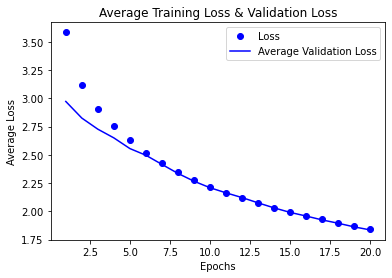

In [117]:
plot_loss(all_loss_8, all_loss_history_8)

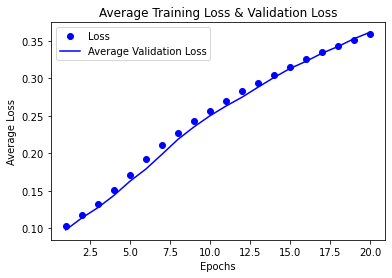

In [118]:
plot_loss(all_acc_8, all_acc_history_8)

In [119]:
print("Average Loss:", np.mean(all_val_loss_8))
print("Average Accuracy:", np.mean(all_val_acc_8))

Average Loss: 1.9043422937393188
Average Accuracy: 0.33938274532556534


In [ ]:
# from tensorflow.keras.layers import Dropout, BatchNormalization

# # Initialising the model 
# lstm_final = Sequential()

# # Defining model: add layers 
# lstm_final.add(Embedding(
#     max_words,
#     EMBEDDING_VECTOR_LENGTH,
#     input_length=max_len,
#     weights=[embedding_matrix],
#     trainable=True,
# )) #glove embedding

# lstm_final.add(LSTM(64, input_shape=(max_len, EMBEDDING_VECTOR_LENGTH))) #LSTM layer
# lstm_final.add(Dropout(0.1))
# lstm_final.add(Dense(256, activation='relu')) 
# lstm_final.add(BatchNormalization())
# lstm_final.add(Dense(128, activation='relu')) 
# lstm_final.add(Dropout(0.1))
# lstm_final.add(Dense(64, activation='relu')) 
# lstm_final.add(BatchNormalization())
# lstm_final.add(Dense(16, activation='softmax')) 

# # Compile model
# lstm_final.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# print(lstm_final.summary())

#### Training the final LSTM model with the COMPLETE training set 

In [120]:
import numpy as np 
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error

K=4
num_val_samples = len(X_train_resampled)//K
num_epochs = 5

all_val_acc_9 = []
all_val_loss_9 = []

all_acc_9 = []
all_loss_9 = []
all_acc_history_9 = []
all_loss_history_9 = []

N_iterations=4
N_folds=5
        
for i in range(N_iterations):
    skf = StratifiedKFold(n_splits=N_folds, shuffle=True)
    
    for j, (train_index, val_index) in enumerate(skf.split(X_train_resampled, y_train_resampled)):
        print('processing fold', j)
        
        partial_train_data = X_train_resampled[train_index]
        val_data = X_train_resampled[val_index]
        
        partial_train_targets = y_train_resampled[train_index]
        val_targets = y_train_resampled[val_index]
        
        # One-hot encode the target labels
        partial_train_targets = to_categorical(partial_train_targets, num_classes=16)
        val_targets = to_categorical(val_targets, num_classes=16)
        
        # Train the model 
        final_lstm_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
        final_lstm_model.fit(np.concatenate([partial_train_data, val_data]), np.concatenate([partial_train_targets, val_targets]), epochs=num_epochs, batch_size=10, verbose=2, validation_data = (val_data, val_targets))        
        

processing fold 0
Epoch 1/5
2346/2346 - 98s - loss: 1.3772 - accuracy: 0.4964 - val_loss: 1.1569 - val_accuracy: 0.5716 - 98s/epoch - 42ms/step
Epoch 2/5
2346/2346 - 72s - loss: 1.3450 - accuracy: 0.5116 - val_loss: 1.3813 - val_accuracy: 0.4746 - 72s/epoch - 31ms/step
Epoch 3/5
2346/2346 - 73s - loss: 1.3353 - accuracy: 0.5114 - val_loss: 1.0845 - val_accuracy: 0.6200 - 73s/epoch - 31ms/step
Epoch 4/5
2346/2346 - 71s - loss: 1.3378 - accuracy: 0.5114 - val_loss: 1.1514 - val_accuracy: 0.5827 - 71s/epoch - 30ms/step
Epoch 5/5
2346/2346 - 71s - loss: 1.3483 - accuracy: 0.5087 - val_loss: 1.0881 - val_accuracy: 0.5972 - 71s/epoch - 30ms/step
processing fold 1
Epoch 1/5
2346/2346 - 77s - loss: 1.3299 - accuracy: 0.5069 - val_loss: 1.0984 - val_accuracy: 0.6201 - 77s/epoch - 33ms/step
Epoch 2/5
2346/2346 - 72s - loss: 1.3414 - accuracy: 0.5084 - val_loss: 1.0961 - val_accuracy: 0.6139 - 72s/epoch - 31ms/step
Epoch 3/5
2346/2346 - 82s - loss: 1.3158 - accuracy: 0.5172 - val_loss: 1.0985 - v

Epoch 5/5
2346/2346 - 71s - loss: 1.1525 - accuracy: 0.6013 - val_loss: 1.0991 - val_accuracy: 0.6135 - 71s/epoch - 30ms/step
processing fold 3
Epoch 1/5
2346/2346 - 78s - loss: 1.1605 - accuracy: 0.5971 - val_loss: 1.0820 - val_accuracy: 0.6476 - 78s/epoch - 33ms/step
Epoch 2/5
2346/2346 - 71s - loss: 1.1614 - accuracy: 0.5974 - val_loss: 1.0257 - val_accuracy: 0.6365 - 71s/epoch - 30ms/step
Epoch 3/5
2346/2346 - 73s - loss: 1.1563 - accuracy: 0.5985 - val_loss: 1.4360 - val_accuracy: 0.5125 - 73s/epoch - 31ms/step
Epoch 4/5
2346/2346 - 93s - loss: 1.1649 - accuracy: 0.6001 - val_loss: 0.9391 - val_accuracy: 0.6941 - 93s/epoch - 40ms/step
Epoch 5/5
2346/2346 - 99s - loss: 1.1552 - accuracy: 0.6036 - val_loss: 1.0111 - val_accuracy: 0.6491 - 99s/epoch - 42ms/step
processing fold 4
Epoch 1/5
2346/2346 - 81s - loss: 1.1378 - accuracy: 0.6022 - val_loss: 0.9052 - val_accuracy: 0.7131 - 81s/epoch - 34ms/step
Epoch 2/5
2346/2346 - 72s - loss: 1.1497 - accuracy: 0.5996 - val_loss: 0.8939 - v

In [122]:
test_loss, test_acc = final_lstm_model.evaluate(X_test_lstm_pad,
                                          y_test_lstm_onehot)

55/55 [==============================] - 1s 21ms/step - loss: 6.8226 - accuracy: 0.1170


From the results above, we can see that the accuracy of the model is not very high. 13.8% 

#### Building the final model with only dropout=0.07

In [123]:
### DROP OUT = 0.07 ###

from tensorflow.keras.layers import Dropout

# Initialising the model 
lstm_model_2 = Sequential()

# Defining model: add layers 
lstm_model_2.add(Embedding(
    max_words,
    EMBEDDING_VECTOR_LENGTH,
    input_length=max_len,
    weights=[embedding_matrix],
    trainable=True,
)) #glove embedding

lstm_model_2.add(Dropout(0.07)) #dropout layer with 0.5 rate
lstm_model_2.add(LSTM(128, input_shape=(max_len, EMBEDDING_VECTOR_LENGTH), return_sequences=True))
lstm_model_2.add(LSTM(64))
lstm_model_2.add(Dense(64, activation='relu'))
lstm_model_2.add(Dropout(0.07))
lstm_model_2.add(Dense(16, activation='softmax'))

# Compile model
lstm_model_2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

print(lstm_model_2.summary())

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, 40, 50)            125000    
                                                                 
 dropout_8 (Dropout)         (None, 40, 50)            0         
                                                                 
 lstm_61 (LSTM)              (None, 40, 128)           91648     
                                                                 
 lstm_62 (LSTM)              (None, 64)                49408     
                                                                 
 dense_51 (Dense)            (None, 64)                4160      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_52 (Dense)            (None, 16)              

#### Training dropout=0.07 lstm model with complete training set

In [ ]:
import numpy as np 
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error

K=4
num_val_samples = len(X_train_resampled)//K
num_epochs = 5

all_val_acc_10 = []
all_val_loss_10 = []

all_acc_10 = []
all_loss_10 = []
all_acc_history_10 = []
all_loss_history_10 = []

N_iterations=4
N_folds=5
        
for i in range(N_iterations):
    skf = StratifiedKFold(n_splits=N_folds, shuffle=True)
    
    for j, (train_index, val_index) in enumerate(skf.split(X_train_resampled, y_train_resampled)):
        print('processing fold', j)
        
        partial_train_data = X_train_resampled[train_index]
        val_data = X_train_resampled[val_index]
        
        partial_train_targets = y_train_resampled[train_index]
        val_targets = y_train_resampled[val_index]
        
        # One-hot encode the target labels
        partial_train_targets = to_categorical(partial_train_targets, num_classes=16)
        val_targets = to_categorical(val_targets, num_classes=16)
        
        # Train the model 
        lstm_model_2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
        lstm_model_2.fit(np.concatenate([partial_train_data, val_data]), np.concatenate([partial_train_targets, val_targets]), epochs=num_epochs, batch_size=10, verbose=2, validation_data = (val_data, val_targets))        
        

processing fold 0
Epoch 1/5
2346/2346 - 105s - loss: 2.7455 - accuracy: 0.0796 - val_loss: 2.6461 - val_accuracy: 0.1076 - 105s/epoch - 45ms/step
Epoch 2/5
2346/2346 - 83s - loss: 2.6256 - accuracy: 0.1117 - val_loss: 2.5661 - val_accuracy: 0.1360 - 83s/epoch - 35ms/step
Epoch 3/5
2346/2346 - 72s - loss: 2.5671 - accuracy: 0.1295 - val_loss: 2.5079 - val_accuracy: 0.1488 - 72s/epoch - 31ms/step
Epoch 4/5
2346/2346 - 71s - loss: 2.5198 - accuracy: 0.1496 - val_loss: 2.4432 - val_accuracy: 0.1795 - 71s/epoch - 30ms/step
Epoch 5/5
2346/2346 - 71s - loss: 2.4520 - accuracy: 0.1770 - val_loss: 2.3569 - val_accuracy: 0.2202 - 71s/epoch - 30ms/step
processing fold 1
Epoch 1/5
2346/2346 - 89s - loss: 2.3671 - accuracy: 0.2086 - val_loss: 2.2334 - val_accuracy: 0.2528 - 89s/epoch - 38ms/step
Epoch 2/5
2346/2346 - 73s - loss: 2.2716 - accuracy: 0.2390 - val_loss: 2.1050 - val_accuracy: 0.3055 - 73s/epoch - 31ms/step
Epoch 3/5
2346/2346 - 72s - loss: 2.1589 - accuracy: 0.2760 - val_loss: 1.9548 -

In [ ]:
test_loss2, test_acc2 = lstm_model_2.evaluate(X_test_lstm_pad,
                                          y_test_lstm_onehot)

In [ ]:
######################################    IGNORE FROM HERE    #####################################

Optimizer

For this project, we will be using Adam as our optimizer as it is a combination of the best properties of AdaGrad, RMSprop and momentum. 

In addition, Adam generally works well in training deep learning models and outperforms other adaptive techniques. 

# Further improvements 

# References

https://stackoverflow.com/questions/53353785/difference-between-k-fold-and-iterated-k-fold-with-shuffling
    
    